# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [11]:
# !mkdir cifar10
# !curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# !tar -xvzf cifar-10-python.tar.gz -C cifar10

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

KeyboardInterrupt: 

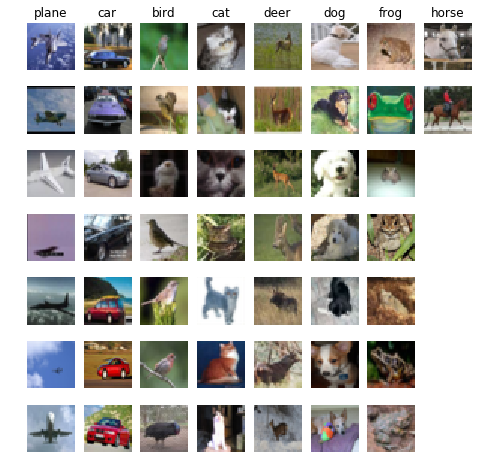

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

Раньше сверточные сети были небольшой глубины (меньше 20 слоев). Сейчас научились делать глубокие нейронки (больше 150 слоев) с помощью линков и активаций на разных глубинах.

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

Могут начать затухать градиенты, первые слои не будут обучаться. Долго обучаются. Могут кончиться деньги на сервера. Исчезнет личная жизнь.


**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

Нейросеточка будет как Эллочка-Людоедка: выучиться ну уж очень плохо. А сеточка хочет много данных. Можно использовать предобученные нейронные сети, сделать файн тюннинг либо использовать веса этой сетки для начальных весов новой сеточки. Второй вариант решения: насемплировать данных бутстрепом, поворотом картинок, наложением шумов и др. преобразованиями.

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

<Ответ>

In [ ]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

Я использовал vgg - pretrained model по этому гайду: https://github.com/Lasagne/Recipes/blob/master/examples/ImageNet%20Pretrained%20Network%20%28VGG_S%29.ipynb
https://github.com/Lasagne/Recipes/blob/master/papers/deep_residual_learning/Deep_Residual_Learning_CIFAR-10.py


In [ ]:
# downloading pre-trained vgg model
# !wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg_cnn_s.pkl

In [61]:
# net = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)

# net = lasagne.layers.Conv2DLayer(net, 15, 3, pad='valid') # сверточный слой

# net = lasagne.layers.Conv2DLayer(net, 10,  2, pad='full')  # сверточный слой

# net = lasagne.layers.DenseLayer(net, num_units=500) # полносвязный слой
# net = lasagne.layers.DropoutLayer(net, 0.5)         # регуляризатор
# net = lasagne.layers.DenseLayer(net, num_units=200) # полносвязный слой

# net = lasagne.layers.DenseLayer(net, num_units = 10, nonlinearity=softma
from lasagne.layers import InputLayer, Conv2DLayer as ConvLayer, Pool2DLayer as PoolLayer, DropoutLayer, FlattenLayer, DenseLayer

In [62]:
def build_model(input_X):
    net = {}
    net['input'] = InputLayer(shape=(None, 3, 32, 32), input_var=input_X)
    net['conv1'] = ConvLayer(net['input'],
                             num_filters=192,
                             filter_size=5,
                             pad=2,
                             flip_filters=False)
    net['cccp1'] = ConvLayer(
        net['conv1'], num_filters=160, filter_size=1, flip_filters=False)
    net['cccp2'] = ConvLayer(
        net['cccp1'], num_filters=96, filter_size=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['cccp2'],
                             pool_size=3,
                             stride=2,
                             mode='max',
                             ignore_border=False)
    net['drop3'] = DropoutLayer(net['pool1'], p=0.5)
    net['conv2'] = ConvLayer(net['drop3'],
                             num_filters=192,
                             filter_size=5,
                             pad=2,
                             flip_filters=False)
    net['cccp3'] = ConvLayer(
        net['conv2'], num_filters=192, filter_size=1, flip_filters=False)
    net['cccp4'] = ConvLayer(
        net['cccp3'], num_filters=192, filter_size=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['cccp4'],
                             pool_size=3,
                             stride=2,
                             mode='average_exc_pad',
                             ignore_border=False)
    net['drop6'] = DropoutLayer(net['pool2'], p=0.5)
    net['conv3'] = ConvLayer(net['drop6'],
                             num_filters=192,
                             filter_size=3,
                             pad=1,
                             flip_filters=False)
    net['cccp5'] = ConvLayer(
        net['conv3'], num_filters=192, filter_size=1, flip_filters=False)
    net['cccp6'] = ConvLayer(
        net['cccp5'], num_filters=10, filter_size=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['cccp6'],
                             pool_size=8,
                             mode='average_exc_pad',
                             ignore_border=False)
    net['output'] = FlattenLayer(net['pool3'])
    net = DenseLayer(net['output'], num_units = 10, nonlinearity=softmax)
    return net

In [63]:
net = build_model(input_X)

In [64]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net)
print all_weights

[W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b]


In [65]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

In [66]:
updates = lasagne.updates.momentum(loss, all_weights, learning_rate=0.01, momentum=0.9);

In [67]:
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates, allow_input_downcast=True)
accuracy_fun = theano.function([input_X,target_y], accuracy, allow_input_downcast=True)

### Вот и всё, пошли её учить

In [68]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [69]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in xrange(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

KeyboardInterrupt: 

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 